In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
block_size = 3
emb_size = 5
n_neurons = 1000

In [6]:
# build dataset

def build_dataset(words):
    
    X, Y = [], []
    for w in words:
        context = [0] * block_size 
        for ch in w + '.':
            ix = stoi[ch] # index of current character
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
          
            context = context[1:] + [ix] # sliding window with indexes
     
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_tr, Y_tr = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_te, Y_te = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# lookup table for embed
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, emb_size), generator=g)
# hidden layer 
W1 = torch.randn((emb_size*block_size, n_neurons), generator=g) * 0.2
b1 = torch.randn(n_neurons, generator=g) * 0.01
# output layer
W2 = torch.randn((n_neurons, 27), generator=g) * 0.01
print(W1.shape, W2.shape)
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

# number of params
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

torch.Size([15, 1000]) torch.Size([1000, 27])
43162


In [414]:
lri = []
lossi = []
stepi = []

In [415]:
initial_iterations = 50000
counter = 0

In [429]:
start_time = time.time()
for i in range(initial_iterations):
    if i == 1:
        print('initial lr', lr)
    # mini batch construct
    ix = torch.randint(0, X_tr.shape[0], (128,))
    
    # forward pass
    emb = C[X_tr[ix]] 
    embv = emb.view(emb.shape[0], block_size * emb_size) 
    
    h = torch.tanh(embv @ W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y_tr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.3 if counter < initial_iterations / 2 else 0.1
    
    if counter > initial_iterations:
        lr = 0.1 if counter < initial_iterations * 1.5 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(counter)
    lossi.append(loss.log10().item())

    counter += 1
    
end_time = time.time()
execution_time = end_time - start_time

print('training done in', execution_time)

initial lr 0.01
training done in 19.11091923713684


2.0292794704437256


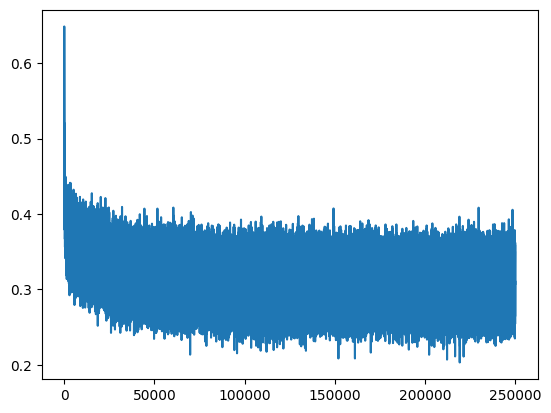

In [430]:
plt.plot(stepi, lossi)
print(loss.item())

In [431]:
# global loss (not local mini batch)

emb = C[X_dev]
embv = emb.view(emb.shape[0], emb_size*block_size) 

h = torch.tanh(embv @ W1 + b1) 
logits = h @ W2 + b2 
print(logits.shape)
loss = F.cross_entropy(logits, Y_dev)
loss.item()

torch.Size([22655, 27])


2.1055686473846436

In [9]:
# global loss (not local mini batch)

emb = C[X_te] # (32, 3, 2)
embv = emb.view(emb.shape[0], emb_size*block_size) # 32, 6

h = torch.tanh(embv @ W1 + b1) 
logits = h @ W2 + b2 
print(logits.shape)
loss = F.cross_entropy(logits, Y_te)
loss.item()

torch.Size([22866, 27])


3.334556818008423

In [432]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] 
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))
        

ruwan.
akiah.
balei.
talett.
rexlynnelle.
emell.
siqya.
mariyaqia.
kuan.
khalix.
alis.
shyanget.
feng.
amiraan.
ary.
gemmi.
defanie.
jalah.
mira.
zaie.
